# Creating a Data-Science/Kaggle Workflow: <br>Predicting Survivors of the Titanic

In this project, we're going to explore a workflow to make competing in the [Kaggle Titanic competition](https://www.kaggle.com/c/titanic/overview) easier, using a pipeline of functions to reduce the number of dimensions we need to focus on.

By defining a workflow, we can give oursleves a framework with which to make iterating on ideas quicker and easier, allowing us to work more efficiently.

In [1]:
# Import libraries we'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, RandomTreesEmbedding
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, GridSearchCV,\
                                    RandomizedSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import minmax_scale, scale
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import warnings
from sklearn.exceptions import ConvergenceWarning

# Show plots in notebook
%matplotlib inline

# Configure graph format
sns.set(style='white', context={'font.size': 12,
 'axes.labelsize': 18,
 'axes.titlesize': 20,
 'xtick.labelsize': 13,
 'ytick.labelsize': 13,
 'legend.fontsize': 12,
 'axes.linewidth': 1.875,
 'grid.linewidth': 1.5,
 'lines.linewidth': 2.25,
 'lines.markersize': 8,
 'patch.linewidth': 1,
 'xtick.major.width': 1.25,
 'ytick.major.width': 1.25,
 'xtick.minor.width': 1,
 'ytick.minor.width': 1,
 'xtick.major.size': 6,
 'ytick.major.size': 6,
 'xtick.minor.size': 4,
 'ytick.minor.size': 4})
plt.style.use('dark_background')

# Read in the data
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

## 1. Exploring the data

In [2]:
# First look at training data
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# First look at holdout/test data
holdout.info()
holdout.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


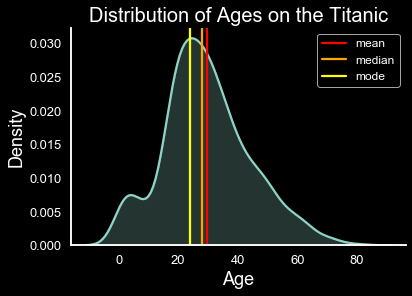

In [4]:
# Plot distribution of ages
sns.kdeplot(train['Age'], shade=True, label='')
sns.despine()
plt.title('Distribution of Ages on the Titanic')
plt.xlabel('Age')
plt.ylabel('Density')
plt.axvline(train['Age'].mean(), color='red', label='mean')
plt.axvline(train['Age'].median(), color= 'orange', label='median')
plt.axvline(train['Age'].mode()[0], color= 'yellow', label='mode')
plt.legend()
plt.show()

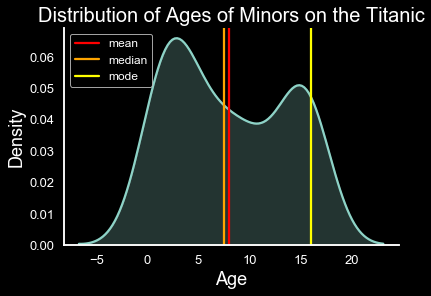

In [5]:
# Plot distribution of minor ages
sns.kdeplot(train['Age'][train['Age'] <= 16], shade=True, label='')
sns.despine()
plt.title('Distribution of Ages of Minors on the Titanic')
plt.xlabel('Age')
plt.ylabel('Density')
plt.axvline(train['Age'][train['Age'] <= 16].mean(), color='red', label='mean')
plt.axvline(train['Age'][train['Age'] <= 16].median(), color= 'orange', label='median')
plt.axvline(train['Age'][train['Age'] <= 16].mode()[0], color= 'yellow', label='mode')
plt.legend()
plt.show()

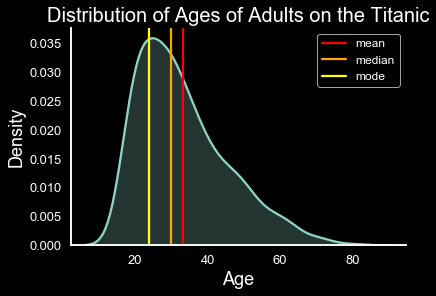

In [6]:
# Plot distribution of adult ages
sns.kdeplot(train['Age'][train['Age'] > 16], shade=True, label='')
sns.despine()
plt.title('Distribution of Ages of Adults on the Titanic')
plt.xlabel('Age')
plt.ylabel('Density')
plt.axvline(train['Age'][train['Age'] > 16].mean(), color='red', label='mean')
plt.axvline(train['Age'][train['Age'] > 16].median(), color= 'orange', label='median')
plt.axvline(train['Age'][train['Age'] > 16].mode()[0], color= 'yellow', label='mode')
plt.legend()
plt.show()

## 2. Data cleaning and feature engineering

In [7]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    avg_median_mode_age_adult = (train['Age'][train['Age'] > 16].median() + 
                                 train['Age'][train['Age'] > 16].median()) / 2
    median_age_minor = train['Age'][train['Age'] <= 16].median()
    
    # 'Master' is a title given to boys/minors
    df.loc[(df['Title'] == 'Master') & (df['Age'].isnull()), 'Age'] = median_age_minor

    df.loc[df['Age'].isnull(), 'Age'] = avg_median_mode_age_adult
    df['isminor'] = df['Age'].apply(lambda age: 1 if age <=16 else 0)
    
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Miss",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Dr",
        "Rev":         "Rev",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,["Age"])
    """
    df = pd.get_dummies(df,prefix=column_name,columns=column_name)
    return df

def num_relatives(df):
    """Calculate the total number of relatives from 2 columns
    
    Usage
    ------
    
    train = num_relatives(train)
    """
    df['relatives'] = df[['SibSp','Parch']].sum(axis=1)
    return df

In [8]:
def process_df(df):
    '''Applies all data cleaning, feature selection, and feature engineering
       functions created thus far to the data set
       
       Usage
       ------
       
       train = process_df(train)'''
    df = process_missing(df)
    df = process_titles(df)
    df = process_age(df)
    df = process_cabin(df)
    
    df["Embarked"] = df["Embarked"].fillna("S")
    
    # We are keeping Pclass as a continuous variable, since it does show order
    for col in ['Title', 'Cabin_type', 'Embarked', 'Sex']:
        df = create_dummies(df, [col])
        
    return df

In [9]:
# Apply feature cleaning/reduction to dataset
train = process_df(train)
holdout = process_df(holdout)

In [10]:
# Observe changes to training set
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Survived            891 non-null    int64  
 2   Pclass              891 non-null    int64  
 3   Name                891 non-null    object 
 4   Age                 891 non-null    float64
 5   SibSp               891 non-null    int64  
 6   Parch               891 non-null    int64  
 7   Ticket              891 non-null    object 
 8   Fare                891 non-null    float64
 9   isminor             891 non-null    int64  
 10  Title_Dr            891 non-null    uint8  
 11  Title_Master        891 non-null    uint8  
 12  Title_Miss          891 non-null    uint8  
 13  Title_Mr            891 non-null    uint8  
 14  Title_Mrs           891 non-null    uint8  
 15  Title_Officer       891 non-null    uint8  
 16  Title_Re

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,isminor,...,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,...,0,0,0,0,1,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,...,0,0,0,0,0,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,...,0,0,0,0,1,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,...,0,0,0,0,0,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,...,0,0,0,0,1,0,0,1,0,1


In [11]:
# Observe changes to holdout/test set
holdout.info()
holdout.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         418 non-null    int64  
 1   Pclass              418 non-null    int64  
 2   Name                418 non-null    object 
 3   Age                 418 non-null    float64
 4   SibSp               418 non-null    int64  
 5   Parch               418 non-null    int64  
 6   Ticket              418 non-null    object 
 7   Fare                418 non-null    float64
 8   isminor             418 non-null    int64  
 9   Title_Dr            418 non-null    uint8  
 10  Title_Master        418 non-null    uint8  
 11  Title_Miss          418 non-null    uint8  
 12  Title_Mr            418 non-null    uint8  
 13  Title_Mrs           418 non-null    uint8  
 14  Title_Officer       418 non-null    uint8  
 15  Title_Rev           418 non-null    uint8  
 16  Title_Ro

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,isminor,Title_Dr,...,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,0,0,...,0,0,0,0,1,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,0,0,...,0,0,0,0,1,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,0,0,...,0,0,0,0,1,0,1,0,0,1
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,0,0,...,0,0,0,0,1,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,0,0,...,0,0,0,0,1,0,0,1,1,0


## 3. Data visualization

In [12]:
# Split data into survivors and non-survivors for data visualizations
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

In [13]:
# Calculate ratio of survivors to deaths
print('survivor/death ratio:', len(survived)/len(died))

survivor/death ratio: 0.6229508196721312


A survivor/death ratio of ~ 0.6 indicates that only approximately 3 out of 5 passengers in the dataset survived the sinking of the Titanic. 

It also means that we have a class imbalance, where survivors are underrepresented in the dataset. We'll have to make sure to account for this when splitting our data for training/validation/testing.

In [14]:
def plot_distribution(column, title, xlabel, ylabel):
    """Plots distributions for column
    
    Usage
    ------
    
    plot_distributions('SibSp', 'title', 'counts', 'column units')
    """
    fig, axes = plt.subplots(2,1,figsize=(6,6), sharex=True)
    train_val_counts = train[column].value_counts().sort_index()
    train_val_counts.plot.bar(ax=axes[0], edgecolor='', label='Total')
    survived_val_counts = survived[column].value_counts().sort_index()
    died_val_counts = died[column].value_counts().sort_index()
    survived_died = pd.concat([survived_val_counts, died_val_counts], axis=1)
    survived_died.columns = ['Survived', 'Died']
    survived_died.plot.bar(ax=axes[1], color=['green','red'], edgecolor='')
    plt.suptitle(title, y=1.05)
    plt.tick_params(left=False)
    axes[1].tick_params('x', rotation=0)
    plt.xlabel(xlabel)
    fig.text(0, 0.5, ylabel, ha="center", va="center", rotation=90)    
    sns.despine()
    plt.legend(loc='best', frameon=False)
    axes[0].legend(loc='best', frameon=False)
    print('Descriptive statistics:')
    print(train[column].describe(), '\n')
    print('Unique Value Counts:')
    print(train[column].value_counts().sort_values(ascending=False))
    plt.tight_layout()
    plt.show()

Descriptive statistics:
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64 

Unique Value Counts:
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


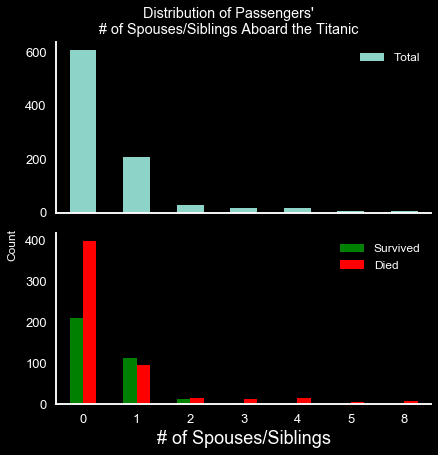

In [15]:
# Plot distributions for number of siblings/spouse
plot_distribution('SibSp', 'Distribution of Passengers\'\n# of Spouses/Siblings Aboard the Titanic', 
                  '# of Spouses/Siblings', 'Count')

Descriptive statistics:
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64 

Unique Value Counts:
0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64


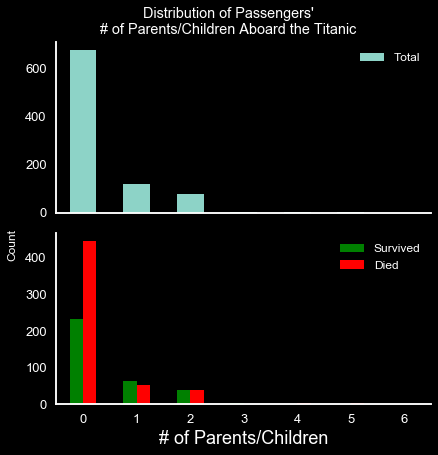

In [16]:
# Plot distributions for number of parents/children
plot_distribution('Parch', 'Distribution of Passengers\'\n# of Parents/Children Aboard the Titanic', 
                  '# of Parents/Children', 'Count')

The majority of passengers aboard the Titanic did not have any other relatives onboard. These "solo" travelers made up the majority of deaths. There were more survivors than deceased passengers with 1, 2, or 3 relatives onboard, likley because passengers with 1, 2, or 3 relatives consisted of families, of which the woman and children were prioritized for evacuation. The same trend does not continue for larger families (passengers with 4+ relatives).

It's clear from our graphs that 'solo' passengers make up the bulk of deaths on the Titanic.
Only 30% of the passengers who had no family members onboard survived. Based off this, we can come up with an idea for a new feature: Was the passenger alone? This will be a binary column containing the value:

* 1 if the passenger has zero family members onboard
* 0 if the passenger has one or more family members onboard

Let's go ahead and create this feature.

In [17]:
def process_isalone(df):
    """Proces the continuous "relatives" column into a boolean number signifiying if passenger is alone.
    
    Usage
    -------
    
    train = process_isalone(train)
    """
    df["relatives"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["relatives"] == 0),"isalone"] = 1
    df = df.drop('relatives', axis=1)
    return df
    
train = process_isalone(train)
holdout = process_isalone(holdout)

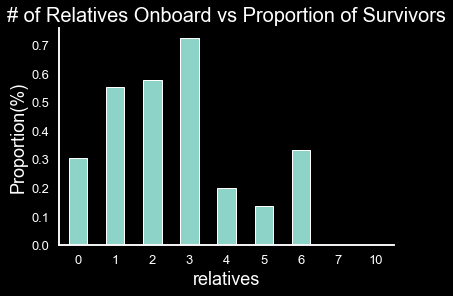

In [18]:
# Plot distribution of for number of relatives vs survivors
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['relatives'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='relatives',values="Survived")
pivot.plot.bar(legend=False)
plt.tick_params('x', rotation=0)
plt.title('# of Relatives Onboard vs Proportion of Survivors')
plt.ylabel('Proportion(%)')
sns.despine()
plt.show()

This chart confirms our observations that passengers with fewer relatives were less likely to survive.
The observation doesn't hold for families of 4 or more members. This could be due to larger families were comprised of more adults and elderly people. Larger familes were possibly more likely to be split up, as woman and children were prioritized on lifeboats.

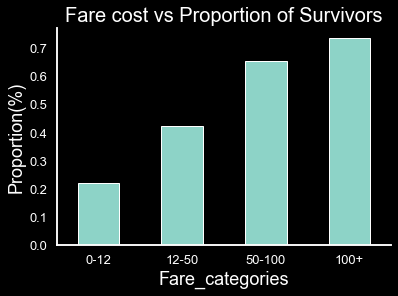

In [19]:
# Plot distribution of for fare cost vs survivors

explore_cols = ["Fare","Survived"]
explore = train[explore_cols].copy()
cut_points = [-1,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]
explore["Fare_categories"] = pd.cut(explore["Fare"],cut_points,labels=label_names)


pivot = explore.pivot_table(index='Fare_categories',values="Survived")
pivot.plot.bar(legend=False)
plt.tick_params('x', rotation=0)
plt.title('Fare cost vs Proportion of Survivors')
plt.ylabel('Proportion(%)')
sns.despine()
plt.show()

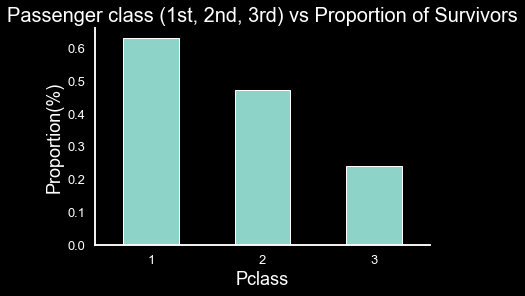

In [20]:
# Plot distribution of for passenger class vs survivors
explore_cols = ["Pclass","Survived"]
explore = train[explore_cols].copy()

pivot = explore.pivot_table(index='Pclass',values="Survived")
pivot.plot.bar(legend=False)
plt.tick_params('x', rotation=0)
plt.title('Passenger class (1st, 2nd, 3rd) vs Proportion of Survivors')
plt.ylabel('Proportion(%)')
sns.despine()
plt.show()

Higher class ticket holders were more likely to survive on the Titanic. They were likely lodged on the upper decks. Lower class ticket holders stayed in cabins on lower decks where the ship flooded first.

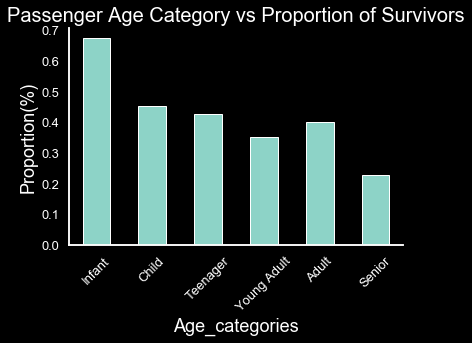

In [21]:
# Plot distribution of age vs survivors
explore_cols = ["Age","Survived"]
explore = train[explore_cols].copy()
cut_points = [0,4,12,18,35,60,130]
label_names = ["Infant","Child","Teenager","Young Adult","Adult","Senior"]
explore["Age_categories"] = pd.cut(explore["Age"],cut_points,labels=label_names)
               
pivot = explore.pivot_table(index='Age_categories',values="Survived")
pivot.plot.bar(legend=False)
plt.tick_params('x', rotation=45)
plt.title('Passenger Age Category vs Proportion of Survivors')
plt.ylabel('Proportion(%)')
sns.despine()
plt.show()

Infants (age < 4) were the most likley age group to survive the Titanic, with approximately 65% of infants surviving the sinking Titanic. Everyone else was not so lucky, falling below a 50% survival rate. Seniors (age > 60) were the least likely to survive, with less than 30% of seniors making it out of the Titantic with their lives.

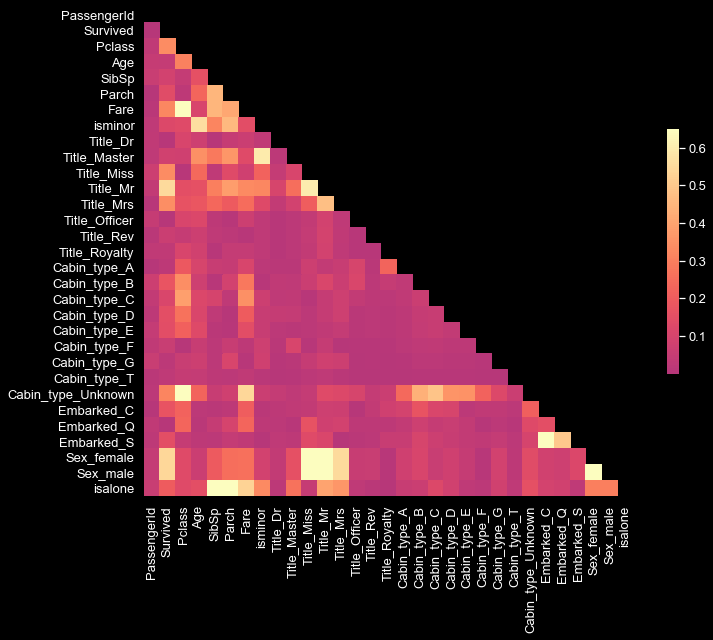

In [22]:
def plot_correlation_heatmap(df):
    """Plot Pearson correlation coeficient matrix/heatmap, showing correlations between features
       and between features and the target column.
       
       Usage
       ------
       
       plot_correlation_heatmap(train)
       """
    corr = abs(df.select_dtypes([np.number]).corr(method='spearman')) # Looking at positive values increases 
                                                                    # interpretability of the heatmap
    
    mask = np.zeros_like(corr, dtype=np.bool) # Mask to reduce redundancy on heatmap display
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(12, 9))
    cmap='magma'

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.65, center=0,
            square=True, cbar_kws={"shrink": .5})
    plt.show()

    # Plot the heatmap
plot_correlation_heatmap(train)

We can see that there is a high correlation between `Sex_female`/`Sex_male` and `Title_Miss`/`Title_Mr`/`Title_Mrs`. We will remove the columns `Sex_female`, `Sex_male` and `Title_Miss` since the title data may be more nuanced (gives the same information, but also the detail of whether the woman is married or not).

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:
* `Title_Master`
* `Cabin_type_T` (Not present in holdout dataset and is the least correlated row)
* `Embarked_S`

We'll only drop these columns from the training dataset (not the holdout dataset), as we'll reduce features even further through feature selection.

In [23]:
# List of columns to drop drop to reduce colinearity. Also drop the target column and individual
# ID unique columns
drop_cols = ['PassengerId', 'Sex_female', 'Sex_male', 'Title_Miss', 
             'Title_Master', 'Cabin_type_T', 'Embarked_S']

# Drop columns from training data
train = train.drop(drop_cols, axis=1)

# Drop non-numeric columns
train = train.select_dtypes([np.number])

In [24]:
# Scale features after having visualized the data
def process_scaling(df):
    """Scale continuous features and drop their orignal values
    
    Usage
    ------
    
    train = process_scaling(train)
    """
    cols = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
    for col in cols:
        df[col + '_scaled'] = minmax_scale(df[col])
        df = df.drop(col, axis=1)
    return df

In [25]:
# Scale features both datasets
train = process_scaling(train)
holdout = process_scaling(holdout)

In [26]:
# Confirm changes
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            891 non-null    int64  
 1   isminor             891 non-null    int64  
 2   Title_Dr            891 non-null    uint8  
 3   Title_Mr            891 non-null    uint8  
 4   Title_Mrs           891 non-null    uint8  
 5   Title_Officer       891 non-null    uint8  
 6   Title_Rev           891 non-null    uint8  
 7   Title_Royalty       891 non-null    uint8  
 8   Cabin_type_A        891 non-null    uint8  
 9   Cabin_type_B        891 non-null    uint8  
 10  Cabin_type_C        891 non-null    uint8  
 11  Cabin_type_D        891 non-null    uint8  
 12  Cabin_type_E        891 non-null    uint8  
 13  Cabin_type_F        891 non-null    uint8  
 14  Cabin_type_G        891 non-null    uint8  
 15  Cabin_type_Unknown  891 non-null    uint8  
 16  Embarked

,Survived,isminor,Title_Dr,Title_Mr,Title_Mrs,Title_Officer,Title_Rev,Title_Royalty,Cabin_type_A,Cabin_type_B,...,Cabin_type_G,Cabin_type_Unknown,Embarked_C,Embarked_Q,isalone,Age_scaled,Fare_scaled,Pclass_scaled,SibSp_scaled,Parch_scaled
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0.271174,0.014151,1.0,0.125,0.0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0.472229,0.139136,0.0,0.125,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0.321438,0.015469,1.0,0.000,0.0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.434531,0.103644,0.0,0.125,0.0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0.434531,0.015713,1.0,0.000,0.0


In [27]:
holdout.info()
holdout.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         418 non-null    int64  
 1   Name                418 non-null    object 
 2   Ticket              418 non-null    object 
 3   isminor             418 non-null    int64  
 4   Title_Dr            418 non-null    uint8  
 5   Title_Master        418 non-null    uint8  
 6   Title_Miss          418 non-null    uint8  
 7   Title_Mr            418 non-null    uint8  
 8   Title_Mrs           418 non-null    uint8  
 9   Title_Officer       418 non-null    uint8  
 10  Title_Rev           418 non-null    uint8  
 11  Title_Royalty       418 non-null    uint8  
 12  Cabin_type_A        418 non-null    uint8  
 13  Cabin_type_B        418 non-null    uint8  
 14  Cabin_type_C        418 non-null    uint8  
 15  Cabin_type_D        418 non-null    uint8  
 16  Cabin_ty

,PassengerId,Name,Ticket,isminor,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Embarked_Q,Embarked_S,Sex_female,Sex_male,isalone,Age_scaled,Fare_scaled,Pclass_scaled,SibSp_scaled,Parch_scaled
0,892,"Kelly, Mr. James",330911,0,0,0,0,1,0,0,...,1,0,0,1,1,0.452723,0.015282,1.0,0.000,0.000000
1,893,"Wilkes, Mrs. James (Ellen Needs)",363272,0,0,0,0,0,1,0,...,0,1,1,0,0,0.617566,0.013663,1.0,0.125,0.000000
2,894,"Myles, Mr. Thomas Francis",240276,0,0,0,0,1,0,0,...,1,0,0,1,1,0.815377,0.018909,0.5,0.000,0.000000
3,895,"Wirz, Mr. Albert",315154,0,0,0,0,1,0,0,...,0,1,0,1,1,0.353818,0.016908,1.0,0.000,0.000000
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",3101298,0,0,0,0,0,1,0,...,0,1,1,0,0,0.287881,0.023984,1.0,0.125,0.111111


## 4. Feature selection

We'll now attempt to reduce the number of features for our model using 5 different methods:
1. Recursive feature elimination with cross-validation (we'll use a random trees model here)
2. Feature importance using mean deacrease in impurity
3. Feature importance using perutations on a full model (also using random trees in this case)
4. Select k best using chi-squared
5. Select k best using f-score
6. Mutual information gain

Thus, we'll have 6 sets of features to train and test on. We'll select the best performing ones

In [28]:
# Split the training data into training and validation/test sets
features = train.columns.drop('Survived')
x_train, x_test, y_train, y_test = train_test_split(train[features], train['Survived'],
                                                    test_size=.1, stratify=train['Survived'],
                                                    random_state=1)

### 4.1 Recursive feature elimination with cross-validation

In [29]:
# Instantiate a dictionary to save feature sets to experiment with later
feature_sets = {}

def select_features(features, target, model):
    """Uses recursive feature elimination with cross validation (RFECV) to select best features.
    Also plots # of features vs scores
    
    Usage
    ------
    columns = select_features(x_train, y_train, RandomForestClassifier())
    """

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    rfe = RFECV(model, cv=kf, scoring='accuracy', n_jobs=-1)
    rfe.fit(features, target)
    
    best_features = list(features.columns[rfe.support_])
    
    plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
    plt.title('Recursive Feature Elimination w/ Cross Validation')
    plt.xlabel("Number of features selected")
    plt.ylabel("Accuracy (%)")

    sns.despine()
    plt.show()
    
    print('Total columns:', len(best_features), '\n')
    print(best_features, '\n')
    
    feature_sets['rfecv_cols'] = best_features
    
    return best_features

In [30]:
def tune_rfecv_estimator(features, target, model, paramdict):
    """Tune the model to be used for feature selection methods, such as 
       recursive feature elimination and comparing feature importances
       
    Usage
    ------

    parameters = tune_rfecv_estimator(x_train, y_train, RandomForestClassifier(),
                                     {'n_estimators': np.linspace(1,200,200),
                                      'max_depth': np.linspace(2,100,99).astype(int),
                                      'max_features': ['sqrt', 'log2']
                                      }
                                      )
    """
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    grid = RandomizedSearchCV(model, param_distributions=paramdict, cv=kf, scoring='roc_auc', 
                              n_iter=60, n_jobs=-1, error_score=0.0, random_state=1)
    with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning,
                                    module="sklearn")
            grid.fit(features, target)
    
    best_score = grid.best_score_
    best_params = grid.best_params_
    best_estimator = grid.best_estimator_
    
    print(str(model).split('(')[0] + ':')
    print('   ', 'Best Parameters:')
    print('   '*2, best_params)
    print('   ', 'Best Score:', best_score, '\n')

    return best_params

In [31]:
%%time
# Instantiate parameter dictionary for random forest classifier model
paramdict = {'n_estimators': np.linspace(1,200,200).astype(int),
             'criterion': ['entropy', 'gini'],
             'max_depth': np.linspace(2,100,99).astype(int),
             'max_features': ['auto','log2', 'sqrt'],
             'min_samples_leaf': [1,5,8,10,15,20,50],
             'min_samples_split': [2,3,5,8,10,12,15,20]
            }

# Get best hyperparameters for random forest classifier
rfparams = tune_rfecv_estimator(x_train, y_train, RandomForestClassifier(random_state=1),
                               paramdict)

# Instantiate the random forest model with tuned hyperparameters
rfclass = RandomForestClassifier(random_state=1).set_params(**rfparams)

RandomForestClassifier:
    Best Parameters:
       {'n_estimators': 160, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 36, 'criterion': 'entropy'}
    Best Score: 0.8790696949747641 

Wall time: 1min 45s


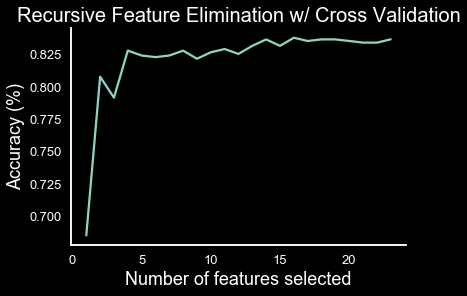

Total columns: 16 

['isminor', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Cabin_type_B', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q', 'isalone', 'Age_scaled', 'Fare_scaled', 'Pclass_scaled', 'SibSp_scaled', 'Parch_scaled'] 

Wall time: 55.2 s


In [32]:
%%time
# Select the best features and plot scores vs number of features calculated by rfecv
rfecv_optimized_cols = select_features(x_train, y_train, rfclass)

### 4.2 Feature importance using mean decrease in impurity and permutations

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

In [33]:
def feature_importances(features, target, params):
    """Calculate feature importances using mean decrease in impurity (MDI) and
    permutations. Set up to use random forest classifier. Return the top features for each method. 
    Plot the calculations for each feature.
    
    Usage
    ------
    
    mid_cols, permu_cols = feature_importances(x_train, y_train,
                                               {'n_estimators': np.linspace(1,200,200),
                                                'max_depth': np.linspace(2,100,99).astype(int),
                                                'max_features': ['sqrt', 'log2']
                                                }
                                                )
    """
    x_train, x_val, y_train, y_val = train_test_split(features, target,
                                                test_size=.222, stratify=target,
                                              random_state=1)

    feature_names = list(x_train.columns)
    forest = RandomForestClassifier(random_state=1, **params)
    forest.fit(x_train, y_train)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    result = permutation_importance(forest, x_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    forest_permu_importances = pd.Series(result.importances_mean, 
                                         index=feature_names).sort_values(ascending=False)

    fig, ax = plt.subplots(2,1, figsize=(8,12))
    forest_importances.plot.bar(yerr=std, ax=ax[0], color='grey')
    forest_permu_importances.plot.bar(yerr=result.importances_std, ax=ax[1], color='grey')
    ax[0].set_title("Feature Importances Using Mean Decrease in Impurity (MDI)")
    ax[0].set_ylabel("Mean decrease in impurity")
    ax[1].set_title("Feature Importances Using Permutation on Full Model")
    ax[1].set_ylabel("Mean accuracy decrease")
    sns.despine()
    fig.tight_layout()
    plt.show()
    
    feature_sets['feature_importance_mdi_cols'] = list(forest_importances.head(7).index)
    feature_sets['perumutation_importance_cols'] = list(forest_permu_importances.head(5).index)
    
    return list(forest_importances.head(7).index), list(forest_permu_importances.head(5).index)

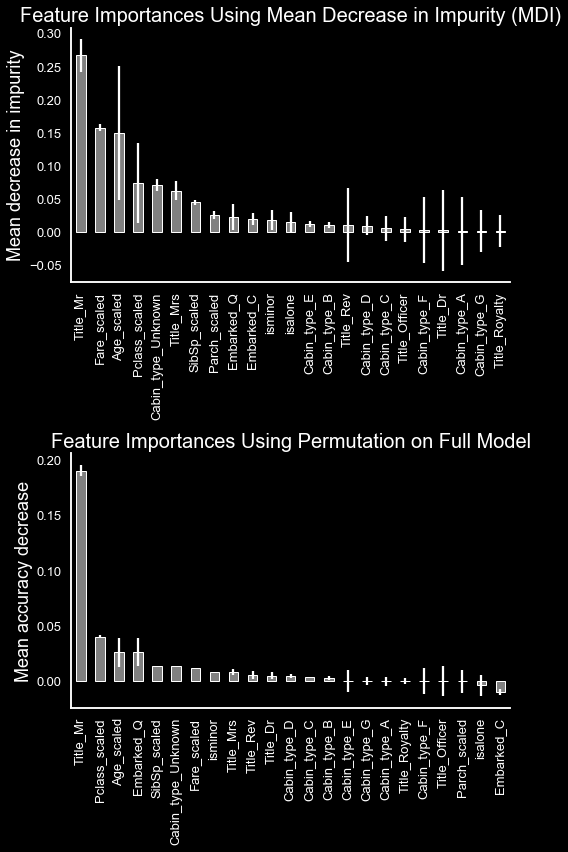

Wall time: 7.05 s


In [34]:
%%time
# Select the best features calulated by mean decrease in impurity and permutations.
# Plot calculations used for each feature
feat_importance_mdi_cols, permutation_importance_cols = feature_importances(x_train, 
                                                                            y_train, rfparams)

### 4.3 Select k best using f-score and chi-squared

In [35]:
def best_k(features, target):
    """Generate a dataframe with f scores, chi squared and p values values for each feature
    
    Usage
    -------
    
    df = best_k(x_train, y_train)
    """ 
    kbestchi = SelectKBest(chi2, k=10).fit(features, target)
    kbestf = SelectKBest(f_classif, k=10).fit(features, target)
    k_df = pd.DataFrame({'feature': features.columns, 'f_score': kbestf.scores_, 
                         'f_pvalue': kbestf.pvalues_, 'chi2': kbestchi.scores_,
                         'chi2_pvalue': kbestchi.pvalues_})
    return k_df

In [36]:
# Calculate f scores, chi-squared values, and p-values for features in the dataset
k_df = best_k(x_train, y_train)

In [37]:
# Display dataframe, sorting by score value
k_df.sort_values('f_score', ascending=False)

,feature,f_score,f_pvalue,chi2,chi2_pvalue
2,Title_Mr,352.891367,1.736728e-65,103.549072,2.540238e-24
3,Title_Mrs,102.400026,9.921510e-23,78.157550,9.514129e-19
14,Cabin_type_Unknown,96.186123,1.616578e-21,21.059844,4.451599e-06
20,Pclass_scaled,92.912305,7.093303e-21,22.972905,1.643008e-06
19,Fare_scaled,50.808551,2.278970e-12,7.132396,7.570349e-03
17,isalone,31.520134,2.723709e-08,12.068825,5.127199e-04
8,Cabin_type_B,25.441412,5.647050e-07,23.329381,1.364989e-06
10,Cabin_type_D,21.352707,4.453053e-06,20.042092,7.575617e-06
15,Embarked_C,19.601150,1.086773e-05,15.587992,7.875313e-05
11,Cabin_type_E,19.376129,1.219207e-05,18.207084,1.981404e-05


In [38]:
# Save the top 5 features for f-score and top 11 features for chi-squared
kbestf_cols = list(k_df.sort_values('f_score', ascending=False).head(5)['feature'])
kbestchi_cols = list(k_df.sort_values('chi2', ascending=False).head(11)['feature'])

feature_sets['kbestf_cols'] = kbestf_cols
feature_sets['kbestchi_cols'] = kbestchi_cols

### 4.4 Mutal information gain

In [39]:
# Calculate mutual information gain for each feature

mutual_info = mutual_info_classif(x_train, y_train, random_state=1)
mutual_info_df = pd.DataFrame({'Feature': x_train.columns, 
                            'mutual_info_gain': mutual_info}).sort_values('mutual_info_gain',
                                                                          ascending=False)
mutual_info_df

,Feature,mutual_info_gain
2,Title_Mr,0.169124
19,Fare_scaled,0.137615
14,Cabin_type_Unknown,0.071334
20,Pclass_scaled,0.061442
21,SibSp_scaled,0.055993
18,Age_scaled,0.050298
11,Cabin_type_E,0.033046
10,Cabin_type_D,0.026600
3,Title_Mrs,0.025837
16,Embarked_Q,0.017898


In [40]:
# Save the top features, ranked by mutual information gain
mutual_info_cols = list(mutual_info_df.head(15)['Feature'])

feature_sets['mutual_info_cols'] = mutual_info_cols

## 5. Model selection

In [41]:
def select_model(features, target):
    """Trains on the dataset, tunes hyperparamters, and calculates scores for various models.
    Return a dictionary containing the best models/paramters. Display best paramters and scores.
    
    Usage
    ------
    
    optimized_models_dictionary = select_models(x_train, y_train)
    """
    models_params_dict = [{'name': 'LogisticRegression',
                      'estimator': LogisticRegression(random_state=1),
                      'hyperparameters': 
                         {
                             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                             'penalty': ['l1', 'l2' 'none', 'elastic_net'],
                             'C': [0.001,.003,0.01,.03,1,3,10,30],
                             'class_weight': ['balanced', 'None'],
                             'l1_ratio': np.linspace(0,1,11)
                         }
                        },
                        {'name': 'GaussianProcessClassifier',
                        'estimator': GaussianProcessClassifier(random_state=1),
                        'hyperparameters':
                           {
                               'optimizer': ['fmin_l_bfgs_b', 'none'],
                               'max_iter_predict': [100,200,500]
                           }
                       },
                     {'name': 'KNeighborsClassifier',
                      'estimator': KNeighborsClassifier(),
                      'hyperparameters':
                         {
                             'n_neighbors': range(1,21),
                             'weights': ['distance', 'uniform'],
                             'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                             'p': [1, 2]
                         }
                     },
                     {'name': 'RandomForestClassifier',
                      'estimator': RandomForestClassifier(random_state=1),
                      'hyperparameters':
                         {
                             'n_estimators': np.linspace(1,200,200).astype(int),
                             'criterion': ['entropy', 'gini'],
                             'max_depth': np.linspace(2,100,99).astype(int),
                             'max_features': ['log2', 'sqrt', 1, 2, 3, 5, 8, 10, 15, 20],
                             'min_samples_leaf': [1,5,8,10,15,20,50],
                             'min_samples_split': [2,3,5,8,10,12,15,20]
                         }
                     },
                      {'name': 'SupportVectorClassifier',
                       'estimator': SVC(random_state=1),
                       'hyperparameters':
                          {
                              'C': [.0001,.001,.01,.1,1,10,100],
                              'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                              'degree': range(1,9),
                              'gamma': np.linspace(.01,.99,99),
                              'coef0': [.0001,.001,.01,.1,0,1.0,8.0,10.0,15.0,20.0],
                              'shrinking': [True, False],
                              'class_weight': ['balanced', 'None'],
                              'max_iter': [5,10,50,100,200,500,1000,5000,10000]   
                          }
                      },
                      {'name': 'SGDClassifier',
                       'estimator': SGDClassifier(random_state=1),
                       'hyperparameters':
                          {
                              'loss': ['hinge', 'log', 'modified_huber', 'epsilon_insensitive'],
                              'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                              'alpha': [.001,.01,.1,1,10],
                              'l1_ratio': np.linspace(.01,.99,99),
                              'max_iter': [5,10,15,20,50,100,500,1000,2000,5000],
                              'learning_rate': ['constant', 'optimal', 'invscaling'],
                              'class_weight': ['balanced', 'None'],
                              'average': [True, False],
                              'eta0': [.00001,.0001,.001,.01,.1,1,10, 1000]
                          }
                      },
                          {'name': 'AdaBoostClassifier',
                           'estimator': AdaBoostClassifier(random_state=1),
                           'hyperparameters':
                              {
                                  'n_estimators': range(50,501,10),
                                  'learning_rate': [.001,.01,.1,1,10]
                              }
                          },
                          {'name': 'GradientBoostingClassifier',
                           'estimator': GradientBoostingClassifier(random_state=1),
                           'hyperparameters':
                              {
                                 'loss': ['deviance','exponential'],
                                 'learning_rate': [.001,.01,.1,1,10],
                                 'n_estimators': np.linspace(1,200,200).astype(int),
                                 'max_depth': np.linspace(2,100,99).astype(int),
                                 'max_features': ['log2', 'sqrt', 1, 2, 3, 5, 8, 10, 15, 20],
                                 'min_samples_leaf': [1,5,8,10,15,20,50],
                                 'min_samples_split': [2,3,5,8,10,12,15,20],
                              }
                          }
                    ]
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    for model in models_params_dict:
        print('    Model:', model['name'])
    
        tuned_model = RandomizedSearchCV(model['estimator'], 
                                  param_distributions=model['hyperparameters'], cv=kf, 
                                  scoring='accuracy', n_iter=60, n_jobs=-1, 
                                  error_score=0.0, random_state=1)
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="sklearn")
            tuned_model.fit(features, target)
            
        model['best_params'] = tuned_model.best_params_
        model['best_score'] =  tuned_model.best_score_
        model['best_estimator'] = tuned_model.best_estimator_
        
        print('   '*2, 'Best parameters:')
        print('    '*3, model['best_params'])
        print('   '*2, 'Best score:', model['best_score'], '\n')
        
    return models_params_dict

In [42]:
%%time
# Instantiate an empty dictionary to save the best feature/model/paramter combinations
optimized_dict = {}

# Iterate over all sets of columns/features we've generated to find the best parameters and scores
# for different models and feature selection methods
for selection_method, cols in feature_sets.items():
    
    print('Feature selection method:', selection_method)
    print('   ','Features:')
    print('   '*2, cols, '\n')
    
    optimized_dict[selection_method] = select_model(x_train[cols], y_train)

# Test all features (those obtained before any feature selection)
print('Feature selection method: None')
print('   ','Features:')
print('   '*2, features, '\n')
optimized_dict['all'] =  select_model(x_train, y_train)

Feature selection method: rfecv_cols
    Features:
       ['isminor', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Cabin_type_B', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q', 'isalone', 'Age_scaled', 'Fare_scaled', 'Pclass_scaled', 'SibSp_scaled', 'Parch_scaled'] 

    Model: LogisticRegression
       Best parameters:
             {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.30000000000000004, 'class_weight': 'None', 'C': 1}
       Best score: 0.8315123456790123 

    Model: GaussianProcessClassifier
       Best parameters:
             {'optimizer': 'fmin_l_bfgs_b', 'max_iter_predict': 100}
       Best score: 0.8202314814814814 

    Model: KNeighborsClassifier
       Best parameters:
             {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'algorithm': 'kd_tree'}
       Best score: 0.8227314814814815 

    Model: RandomForestClassifier
       Best parameters:
             {'n_estimators': 154, 'min_samples_split': 10, 'min_samples_leaf': 1, 'm

       Best parameters:
             {'optimizer': 'fmin_l_bfgs_b', 'max_iter_predict': 100}
       Best score: 0.8015740740740741 

    Model: KNeighborsClassifier
       Best parameters:
             {'weights': 'uniform', 'p': 2, 'n_neighbors': 17, 'algorithm': 'ball_tree'}
       Best score: 0.8040740740740739 

    Model: RandomForestClassifier
       Best parameters:
             {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 8, 'max_depth': 18, 'criterion': 'gini'}
       Best score: 0.8178086419753086 

    Model: SupportVectorClassifier
       Best parameters:
             {'shrinking': False, 'max_iter': 10000, 'kernel': 'rbf', 'gamma': 0.66, 'degree': 5, 'coef0': 20.0, 'class_weight': 'balanced', 'C': 1}
       Best score: 0.7990432098765432 

    Model: SGDClassifier
       Best parameters:
             {'penalty': 'l2', 'max_iter': 5000, 'loss': 'epsilon_insensitive', 'learning_rate': 'constant', 'l1_ratio': 0.9600000000000001, 'eta0':

Since tunining the parameters for all four models takes upwards of 20 minutes, specifcally the neural network, the best scores and parameters from the first run are recorded below for each model (Some of the `model_selection` hyperparameter code has since been modified).

* Model: LogisticRegression
    * Best parameters:
         {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}
    * Best score: 0.8069538077403247 

* Model: KNeighborsClassifier
    * Best parameters:
         {'algorithm': 'ball_tree', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
    * Best score: 0.8294007490636706 

* Model: RandomForestClassifier
    * Best parameters:
         {'n_estimators': 142, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'gini'}
    * Best score: 0.842896379525593 

* Model: MLPClassifier (**Removed from code since it's not the best and incurs lengthy train times**)
    * Best parameters:
         {'solver': 'lbfgs', 'shuffle': False, 'momentum': 0.15000000000000002, 'max_iter': 200, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (25, 25, 25), 'alpha': 0.0001, 'activation': 'logistic'}
    * Best score: 0.8271410736579276 
  

The random forest classifier performed the best, with an accuracy score of ~84.29%.
We'll train a random forest classifier using the best parameters from the `model_selection` function.

In [43]:
# Function to train, validate, and test model with tuned hyperparameters
def validate_model(x_train, x_test, y_train_, y_test, tuned_model):
    """Trains, validates and tests a model. Displays results.
    
    Usage
    ------
    
    validate_model(x_train, x_test, y_train, y_test, RandomForestClassifier())
    """
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = tuned_model

    model.fit(x_train, y_train)

    scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy')
    avg_val_score = np.mean(scores)
    std = np.std(scores)

    train_predictions = model.predict(x_train)
    train_score = accuracy_score(y_train, train_predictions)

    test_predictions = model.predict(x_test)
    test_score = accuracy_score(y_test, test_predictions)
    
    print(str(model).split('(')[0])
    print('   ', 'train score:', train_score)
    print('   ', 'valdation score:', avg_val_score, 'standard_deviation:', std)
    print('   ', 'test score:', test_score, '\n')

In [44]:
# Iterate over the best feature/model combinations to calculate train, validation, and test scores

feature_sets['all'] = x_train.columns
for sel_method in list(feature_sets.keys()):
    
    cols = feature_sets[sel_method]
    
    
    print('Feature selection method:', sel_method)
    print(' Features:', cols, '\n')
    
    
    for i in range(8):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module="sklearn")
            validate_model(x_train[cols], x_test[cols], y_train, y_test,
                           optimized_dict[sel_method][i]['best_estimator'])

Feature selection method: rfecv_cols
 Features: ['isminor', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Cabin_type_B', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q', 'isalone', 'Age_scaled', 'Fare_scaled', 'Pclass_scaled', 'SibSp_scaled', 'Parch_scaled'] 

LogisticRegression
    train score: 0.8414481897627965
    valdation score: 0.8315123456790123 standard_deviation: 0.028796296296296296
    test score: 0.7666666666666667 

GaussianProcessClassifier
    train score: 0.8539325842696629
    valdation score: 0.8202314814814814 standard_deviation: 0.024433788712850037
    test score: 0.7777777777777778 

KNeighborsClassifier
    train score: 0.8764044943820225
    valdation score: 0.8227314814814815 standard_deviation: 0.030448359946913254
    test score: 0.7777777777777778 

RandomForestClassifier
    train score: 0.9076154806491885
    valdation score: 0.8402469135802468 standard_deviation: 0.030200092887692237
    test score: 0.8 

SVC
    train score: 0.

GaussianProcessClassifier
    train score: 0.8389513108614233
    valdation score: 0.8202623456790124 standard_deviation: 0.027768092447301208
    test score: 0.8 

KNeighborsClassifier
    train score: 0.8514357053682896
    valdation score: 0.8314969135802469 standard_deviation: 0.028380082770837034
    test score: 0.7777777777777778 

RandomForestClassifier
    train score: 0.898876404494382
    valdation score: 0.8402932098765431 standard_deviation: 0.043434735148509034
    test score: 0.7777777777777778 

SVC
    train score: 0.8239700374531835
    valdation score: 0.8190277777777778 standard_deviation: 0.03892879896540461
    test score: 0.7666666666666667 

SGDClassifier
    train score: 0.7990012484394506
    valdation score: 0.7915432098765433 standard_deviation: 0.039739485154995244
    test score: 0.7888888888888889 

AdaBoostClassifier
    train score: 0.8476903870162297
    valdation score: 0.8253240740740742 standard_deviation: 0.04153892455380158
    test score: 0.744444

In [45]:
def save_submission_file(trained_model, x_cols, file_name='titanic_submission.csv'):

    predictions = trained_model.predict(holdout[x_cols])
    submission_df = pd.DataFrame({'PassengerId': holdout['PassengerId'], 
                                  'Survived': predictions})
    submission_df.to_csv(file_name, index=False)
    print(predictions)

In [46]:
# Save and submit various submission files

# Random forest using k best f-score columns
best_model = optimized_dict['kbestf_cols'][3]['best_estimator']
save_submission_file(best_model, feature_sets['kbestf_cols'], '2021_kbestf_rf.csv')

# Gradient boosted classifier using k best f-score columns
best_model = optimized_dict['kbestf_cols'][7]['best_estimator']
save_submission_file(best_model, feature_sets['kbestf_cols'], '2021_kbestf_gbc.csv')

# Gaussian process classifier using mutual information gain columns
best_model = optimized_dict['mutual_info_cols'][1]['best_estimator']
save_submission_file(best_model, feature_sets['mutual_info_cols'], '2021_mutual_info_gaussian_process_classifier.csv')

# K nearet neighbors using mean impurity difference columns
best_model = optimized_dict['feature_importance_mdi_cols'][2]['best_estimator']
save_submission_file(best_model, feature_sets['feature_importance_mdi_cols'], '2021_mean_impurity_diff_knn.csv')

# Gaussian process classifier using all columns
best_model = optimized_dict['all'][1]['best_estimator']
save_submission_file(best_model, feature_sets['all'], '2021_all_cols_gaussian_process_classifier.csv')

# Random forest using all columns
best_model = optimized_dict['all'][3]['best_estimator']
save_submission_file(best_model, feature_sets['all'], 
                     '2021_all_cols_rf.csv')

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 

In [47]:
# We'll also submit 3 simple random forest model without tuning hyperparameters using the features from 
# recursive feature elimination and k best f-score, as well as using all features without feature selection
best_model = RandomForestClassifier(random_state=1, max_depth=5, n_estimators=500)
best_model.fit(x_train[feature_sets['rfecv_cols']], y_train)
save_submission_file(best_model, feature_sets['rfecv_cols'], 
                     '2021_randomforrest_class_notuning_rfecv.csv')

best_model = RandomForestClassifier(random_state=1, max_depth=5, n_estimators=500)
best_model.fit(x_train[feature_sets['kbestf_cols']], y_train)
save_submission_file(best_model, feature_sets['kbestf_cols'], 
                     '2021_randomforrest_class_notuning_kbestf_cols.csv')

best_model = RandomForestClassifier(random_state=1, max_depth=5, n_estimators=500)
best_model.fit(x_train[feature_sets['all']], y_train)
save_submission_file(best_model, feature_sets['all'], 
                     '2021_randomforrest_class_notuning_all_cols.csv')

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 

## Conclusion

We created a reproducible workflow to help us iterate over ideas and continue to improve the accuracy of our predictions. We also created helper functions which will make feature selection, model selection/tuning and creating submissions much easier as we continue to explore the data and create new features.

Thus far, here are the best features, model, and hyperparamters for the best score we've acheived:

* Features:
    * ['Title_Mr', 'Title_Mrs', 'Pclass_scaled', 'Fare_scaled', 'isalone']
    
* Model: RandomForestClassifier<br>
    * Best parameters: 
        * {'n_estimators': 154, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 5, 'max_depth': 23, <br> 'criterion': 'gini'}
    * train score: 0.8913857677902621<br>
    * valdation score: 0.8289814814814814 standard_deviation: 0.033459252904664075 <br>
    * test score: 0.8
    * **Submitted prediction score on Kaggle: 0.77990**
        * **Rank: 3505 / 50361 (*93rd percentile*)**
    
This notebook is an example workflow and not necessarily the most effiecient method of structuring a machine learning project.
Given this is our first machine learning project, it's safe to say we did pretty well. As of September 2021 this submission is ranked in the top 7%!
    
### Next steps

* Continue to explore the data and create new features, following the workflow and using the functions we created.
* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use some different algorithms in the `select_model()` function, like support vector machines, stochastic gradient descent or perceptron linear models.
* Use learning curves to plot training and validation loss to get a better idea if our models have a bias or variance problem.
    * Take action accordingly.